# RIce Leaf Disease Prediction

## **Introduction**

Rice is a staple food crop and is highly susceptible to several diseases that can affect crop yield. This project aims to detect three major rice leaf diseases — Leaf Blast, Bacterial Blight, and Brown Spot using image classification techniques. The dataset consists of labeled images representing these diseases.


####**Goal**
The goal of this project is to develop a model that can classify three major attacking diseases in rice plants: Leaf Blast, Bacterial Blight, and Brown Spot. These diseases can severely affect the yield of rice, and early detection can help in mitigating the damage. We aim to classify rice leaf images into these three categories using Convolutional Neural Networks (CNNs).

In [ ]:
# Importing Some Necessery Library
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


## **Dataset Overview**

The dataset contains images of rice leaves categorized into three disease types:

* Bacterial Leaf Blight

* Brown Spot

* Leaf Smut

Each image is stored in respective folders, and each folder contains images of leaves showing symptoms of a particular disease. The dataset is extracted from zip files and is ready for further preprocessing.

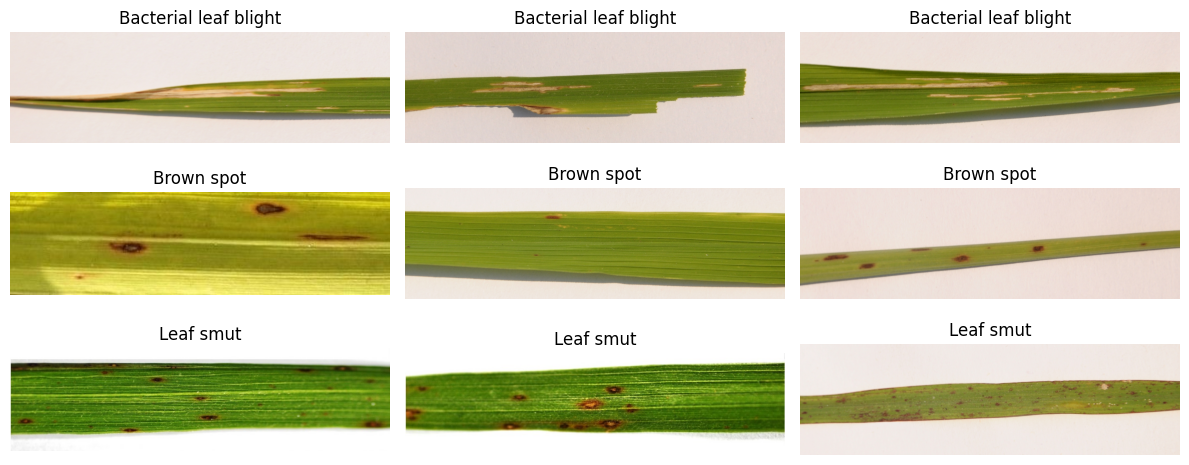

In [ ]:

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import zipfile

zip_files = [
    "/content/Bacterial leaf blight-20200814T055237Z-001.zip",
    "/content/Brown spot-20200814T055208Z-001.zip",
    "/content/Leaf smut-20200814T055530Z-001.zip",
]

extract_path = "/content/images_dataset"

for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:  # Open each zip file in read mode
        zip_ref.extractall(extract_path)  # Extract to the common path

# Categories of images
categories = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]

# Create a dictionary to store image paths for each category
category_images = {}
for category in categories:
    category_images[category] = [
        os.path.join(extract_path, category, file)
        for file in os.listdir(os.path.join(extract_path, category))
        if file.endswith((".jpg","JPG"))
    ][:3]  # Get only the first 3 images for each category


# Display the images
plt.figure(figsize=(12, 5))  # Adjust figure size for 3 images per category
for i, category in enumerate(categories):
    for j, image_path in enumerate(category_images[category]):
        plt.subplot(len(categories), 3, i * 3 + j + 1)  # Adjust subplot grid
        plt.imshow(img_to_array(load_img(image_path)) / 255.0)  # Load and display image
        plt.title(category)  # Set title as category name
        plt.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

##### Counting the total Image

In [ ]:
total_image_count = 0
categories = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]
for category in categories: # Removed extra indentation here
    folder_path = os.path.join(extract_path, category)
    for file in os.listdir(folder_path):
        if file.endswith((".jpg", ".JPG")):
            total_image_count += 1 # Added 1 to count images
print("Total number of images:", total_image_count)

Total number of images: 119


## **Data Preprocessing**

This includes:

* Resizing

* Normalizing

* Label encoding

In this section, the images are resized to a uniform size (128x128 pixels) and normalized by scaling the pixel values between 0 and 1. The labels are encoded using LabelEncoder, and the dataset is split into training, validation, and test sets.

In [ ]:
from sklearn.preprocessing import LabelEncoder

image_size = (128, 128)
images = []
labels = []

for category in categories:
    folder_path = os.path.join(extract_path, category)
    for file in os.listdir(folder_path):
        if file.endswith((".jpg", ".jpeg", ".png", ".JPG")):
            image_path = os.path.join(folder_path, file)
            img = load_img(image_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(category)

# Convert to numpy arrays
X = np.array(images)
le = LabelEncoder()
y = le.fit_transform(labels)  # Converts categories to [0, 1, 2]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Optional: split part of data for validation
)

# Fit the generator to your data
datagen.fit(np.array(images))


###  **Generate Augmented Images and Add to Dataset**
To prevent overfitting and increase dataset diversity, data augmentation is applied to the images. This includes techniques such as rotation, zoom, width and height shifts, and horizontal flipping.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Set up augmentation
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Convert original data to arrays
X = np.array(images)
y = np.array(labels)

# Generate augmented images
augmented_images = []
augmented_labels = []
for i in range(len(X)):
    img = X[i].reshape((1,) + X[i].shape)
    label = y[i]
    count = 0
    for batch in augmentor.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        count += 1
        if count >= 5:  # Generate 5 augmented images per original
            break

# Combine original and augmented data
X_all = np.concatenate((X, np.array(augmented_images)))
y_all = np.concatenate((y, np.array(augmented_labels)))

print("Original dataset size:", len(X))
print("Augmented dataset size:", len(X_all))


Original dataset size: 119
Augmented dataset size: 714


In [ ]:
X

array([[[[0.9254902 , 0.88235295, 0.85882354],
         [0.9254902 , 0.88235295, 0.85882354],
         [0.9372549 , 0.88235295, 0.87058824],
         ...,
         [0.93333334, 0.8901961 , 0.88235295],
         [0.9372549 , 0.8980392 , 0.8901961 ],
         [0.92941177, 0.89411765, 0.8745098 ]],

        [[0.93333334, 0.8745098 , 0.85490197],
         [0.9254902 , 0.88235295, 0.85882354],
         [0.92941177, 0.8862745 , 0.87058824],
         ...,
         [0.9372549 , 0.90588236, 0.89411765],
         [0.94509804, 0.90588236, 0.8980392 ],
         [0.9372549 , 0.9019608 , 0.88235295]],

        [[0.9372549 , 0.8862745 , 0.85490197],
         [0.9372549 , 0.8862745 , 0.8627451 ],
         [0.92941177, 0.8862745 , 0.87058824],
         ...,
         [0.9411765 , 0.9098039 , 0.8980392 ],
         [0.9372549 , 0.90588236, 0.89411765],
         [0.9372549 , 0.90588236, 0.89411765]],

        ...,

        [[0.92941177, 0.8862745 , 0.8627451 ],
         [0.92941177, 0.8862745 , 0.8627451 ]

In [ ]:
y

array(['Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight',

### **Splitting into training and Testing**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
X_train

array([[[[0.94509804, 0.9098039 , 0.8901961 ],
         [0.92941177, 0.9098039 , 0.8862745 ],
         [0.9372549 , 0.9098039 , 0.8862745 ],
         ...,
         [0.92941177, 0.87058824, 0.8509804 ],
         [0.9254902 , 0.8745098 , 0.8509804 ],
         [0.9137255 , 0.87058824, 0.84705883]],

        [[0.9411765 , 0.90588236, 0.8862745 ],
         [0.9372549 , 0.9098039 , 0.8862745 ],
         [0.93333334, 0.90588236, 0.88235295],
         ...,
         [0.92941177, 0.87058824, 0.8509804 ],
         [0.9254902 , 0.8745098 , 0.8509804 ],
         [0.92941177, 0.87058824, 0.85882354]],

        [[0.9372549 , 0.9019608 , 0.8745098 ],
         [0.9372549 , 0.90588236, 0.89411765],
         [0.9372549 , 0.90588236, 0.8980392 ],
         ...,
         [0.9098039 , 0.8392157 , 0.8235294 ],
         [0.92941177, 0.8784314 , 0.85490197],
         [0.9254902 , 0.8666667 , 0.85490197]],

        ...,

        [[0.94509804, 0.90588236, 0.8980392 ],
         [0.9411765 , 0.9019608 , 0.89411765]

In [ ]:
y_train

array(['Bacterial leaf blight', 'Bacterial leaf blight', 'Leaf smut',
       'Leaf smut', 'Leaf smut', 'Leaf smut', 'Brown spot',
       'Bacterial leaf blight', 'Brown spot', 'Brown spot', 'Leaf smut',
       'Bacterial leaf blight', 'Leaf smut', 'Brown spot', 'Leaf smut',
       'Leaf smut', 'Bacterial leaf blight', 'Leaf smut', 'Leaf smut',
       'Brown spot', 'Brown spot', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Bacterial leaf blight', 'Brown spot',
       'Leaf smut', 'Brown spot', 'Leaf smut', 'Leaf smut', 'Leaf smut',
       'Bacterial leaf blight', 'Leaf smut', 'Leaf smut', 'Leaf smut',
       'Bacterial leaf blight', 'Brown spot', 'Brown spot', 'Leaf smut',
       'Brown spot', 'Leaf smut', 'Leaf smut', 'Leaf smut', 'Brown spot',
       'Brown spot', 'Bacterial leaf blight', 'Brown spot',
       'Bacterial leaf blight', 'Bacterial leaf blight',
       'Bacterial leaf blight', 'Brown spot', 'Leaf smut',

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Assuming X has shape (num_samples, 128, 128, 3) and y has shape (num_samples,)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Assuming X_train has less than 100 samples
# Adjust the split to prevent an empty X_train
validation_size = min(100, int(0.2 * len(X_train))) # validation size to be 20% of X_train but not exceeding 100

# break training set into training and validation sets
(X_train, X_valid) = X_train[validation_size:], X_train[:validation_size]
(y_train, y_valid) = y_train[validation_size:], y_train[:validation_size]


# print shape of training set
print('x_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

#from keras.utils import np_utils
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder to your original labels (y)
label_encoder.fit(y)

# Transform the labels in y_train, y_test, and y_valid to numerical values
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_valid = label_encoder.transform(y_valid)

# one-hot encode the labels
num_classes = len(np.unique(y)) # Calculate total number of classes from original labels (y)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes) # One-hot encode y_valid as well

x_train shape: (76, 128, 128, 3)
76 train samples
24 test samples
19 validation samples


## **Define the Model Architecture**
The model is built using Convolutional Neural Networks (CNN), which are well-suited for image classification tasks. The architecture includes several convolutional layers followed by max-pooling layers to capture important features in the image.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu',input_shape=(128, 128, 3))) # Changed input shape to (128, 128, 3)
#16 filters with 2X2 kernel with padding size same as iput and output
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Flatten())# Coverting data into 1D array
model.add(Dense(700, activation='relu'))#500 nurons with relu AF
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax')) # Changed output to 3 for 3 classes

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### **Training the Model**
The model is compiled with categorical crossentropy as the loss function, RMSprop as the optimizer, and accuracy as the evaluation metric. The model is trained with early stopping and checkpointing to avoid overfitting.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

hist = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpointer, early_stop],
    verbose=1,
    shuffle=True
)



Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2223 - loss: 1.1236
Epoch 1: val_loss improved from inf to 1.10863, saving model to model.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2358 - loss: 1.1248 - val_accuracy: 0.2632 - val_loss: 1.1086
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4120 - loss: 1.1985
Epoch 2: val_loss improved from 1.10863 to 1.09310, saving model to model.weights.best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4110 - loss: 1.2535 - val_accuracy: 0.2632 - val_loss: 1.0931
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3684 - loss: 1.0978
Epoch 3: val_loss did not improve from 1.09310
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3651 - loss: 1.0974 - val_accuracy: 0.2105 - val_loss: 1.3240
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3972 - loss: 1.0785
Epoch 4: val_loss did not improve from 1.09310
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3966 - l

## **Model Evaluation**
After training, the model's performance is evaluated on the test set. We use accuracy to assess the performance, and visualize predictions alongside true labels for random test images.

In [ ]:
model.load_weights('model.weights.best.keras')

##### Visualize Some Predictions

In [ ]:
# get predictions on the test set
y_hat = model.predict(X_test)

cifar10_labels = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


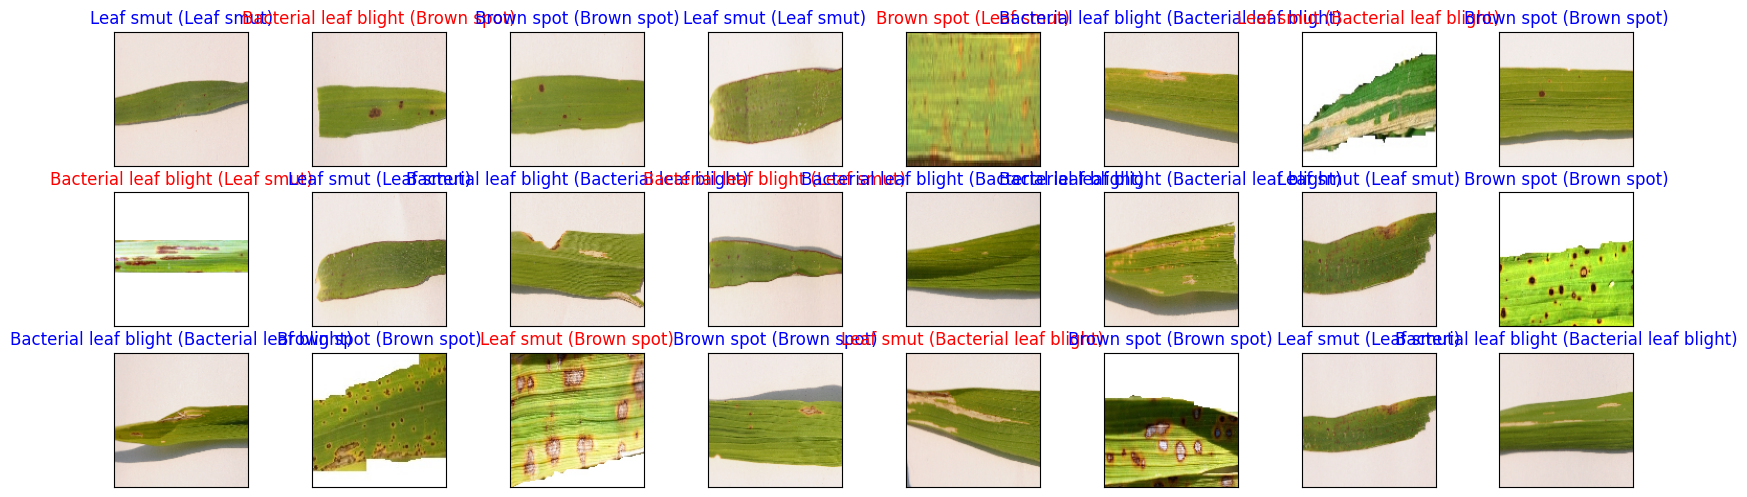

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
# Get the number of samples in x_test
num_samples = X_test.shape[0]

# Ensure 'size' is less than or equal to the number of samples in x_test
sample_size = min(num_samples, 32)

for i, idx in enumerate(np.random.choice(num_samples, size=sample_size, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [ ]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 70.8333%


## **Conclusion**

In this project, I created a model to identify three common rice plant diseases using images of rice leaves. At first, I had only 119 images, which was too few for the model to work well. Because of the small number of images, the model didn't give great results.

To solve this, I used data augmentation, which means I made 5 new images from each original one. This helped to make the dataset bigger and improved the model's performance.

I also noticed that using different hardware made a big difference. When I trained the model using a T4 GPU, it reached 70% accuracy. But when I used a CPU, the accuracy was much lower—only around 50-60%. This shows how using a GPU can make the model faster and more accurate.

In short, using data augmentation to increase the number of images and a GPU for faster processing helped the model perform much better. This project highlights the importance of having enough data and good hardware when working on image classification tasks.